In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd

from utility import get_all_files_paths
from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch

In [2]:
# dataset_path="data/spec/fma_small"
dataset_path = "data/spec/GTZAN_646"
model_save_path = "models/Echoes"
csv_save_path = "output/Echoes_output"
encoded_space_dim = 128

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

In [3]:
class AudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        data = data[np.newaxis, :, :]  # Add a channel dimension
        data = torch.tensor(data, dtype=torch.float32)
        
        # Extract label from file name
        filename = os.path.basename(file_path)
        label_str = filename.split('.')[0]
        label = self.label_to_index(label_str)
        
        return data, label

    @staticmethod
    def label_to_index(label_str):
        label_map = {'blues': 'blues', 'disco': 'disco', 'rock': 'rock', 'metal': 'metal', 'classical': 'classical', 'pop': 'pop', 'reggae':'reggae','country':'country', 'hiphop':'hiphop', 'jazz':'jazz'}  # Extend this as needed
        # label_map = {'Blues': 'Blues', 'Classical': 'Classical', 'Country': 'Country', 'Electronic': 'Electronic', 'Experimental': 'Experimental', 'Folk': 'Folk', 'genre_unknown':'genre_unknown','Instrumental':'Instrumental', 'Hip-Hop':'Hip-Hop', 'International':'International', 'Jazz':'Jazz', 'Pop':'Pop', 'Rock':'Rock', 'Soul-RnB':'Soul-RnB', 'Spoken':'Spoken'}  # Extend this as needed
        return label_map.get(label_str, -1)  # Return -1 if label is not found

genres = ['blues', 'disco', 'rock', 'metal', 'pop', 'classical', 'reggae', 'country','hiphop','jazz']
# genres = ['Blues', 'Blues', 'rock', 'Classical', 'Country', 'Electronic', 'Experimental', 'Folk','genre_unknown','Instrumental', 'Hip-Hop', 'International', 'Jazz', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

genre_file_paths = {genre: get_all_files_paths(f"{dataset_path}/{genre}", [".npy"]) for genre in genres}

train_file_paths = []
valid_file_paths = []
test_file_paths = []

for genre, paths in genre_file_paths.items():
    m = len(paths)
    test_size = int(m * 0.2)
    valid_size = int((m - test_size) * 0.1)
    train_size = m - test_size - valid_size
    
    paths = np.array(paths)
    np.random.shuffle(paths)
    
    train_paths = paths[:train_size]
    valid_paths = paths[train_size:train_size + valid_size]
    test_paths = paths[train_size + valid_size:]
    
    train_file_paths.extend(train_paths)
    valid_file_paths.extend(valid_paths)
    test_file_paths.extend(test_paths)

train_dataset = AudioDataset(train_file_paths)
valid_dataset = AudioDataset(valid_file_paths)
test_dataset = AudioDataset(test_file_paths)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 720
Validation set size: 80
Test set size: 200


In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder)
lr = 1e-5

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.05, inplace=True)
    (2): Linear(in_features=512, out_features=167936, bias=True)
    (3): LeakyReLU(negative_slope=0.05, inplace=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 16, 41))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.05, inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), ou

In [5]:
num_epochs = 500
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
	train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
	val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
	print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	diz_loss['train_loss'].append(train_loss)
	diz_loss['val_loss'].append(val_loss)

	if (epoch+1)%20 ==0: 
		torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
		torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	# plot_ae_outputs(encoder,decoder,n=10)


 EPOCH 1/500 	 train loss 1.3892775774002075 	 val loss 0.3352344334125519

 EPOCH 2/500 	 train loss 1.2183080911636353 	 val loss 0.3333692252635956

 EPOCH 3/500 	 train loss 1.0751334428787231 	 val loss 0.35226869583129883

 EPOCH 4/500 	 train loss 0.952137291431427 	 val loss 0.44902241230010986

 EPOCH 5/500 	 train loss 0.8471887111663818 	 val loss 0.5038152933120728

 EPOCH 6/500 	 train loss 0.7564983367919922 	 val loss 0.49795499444007874

 EPOCH 7/500 	 train loss 0.6790043711662292 	 val loss 0.4658529460430145

 EPOCH 8/500 	 train loss 0.6109701991081238 	 val loss 0.4285334050655365

 EPOCH 9/500 	 train loss 0.5520099401473999 	 val loss 0.3951238691806793

 EPOCH 10/500 	 train loss 0.5021452903747559 	 val loss 0.3622402548789978

 EPOCH 11/500 	 train loss 0.4572185277938843 	 val loss 0.33406877517700195

 EPOCH 12/500 	 train loss 0.4177480936050415 	 val loss 0.3079608976840973

 EPOCH 13/500 	 train loss 0.384197473526001 	 val loss 0.28419727087020874

 EPO

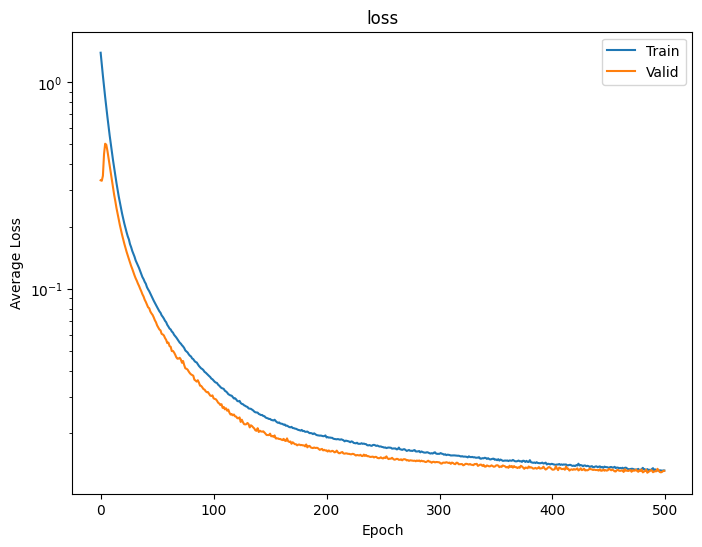

In [6]:
import matplotlib.pyplot as plt
# Plot losses
plt.figure(figsize=(8,6))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [10]:
encoder_path=f"{model_save_path}/encoder.pth"
decoder_path=f"{model_save_path}/decoder.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

encoder=load_encoder(encoder_path, encoded_space_dim)
# decoder=load_decoder(decoder_path, 64)
encoder = encoder.to(device)

In [11]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/gtzan_encoded.csv", index=False)
encoded_samples

100%|██████████| 200/200 [00:00<00:00, 586.88it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,Enc. Variable 126,Enc. Variable 127,label
0,-0.381442,-0.348558,2.011298,2.378877,4.011207,2.152078,3.671695,-2.307898,-2.117263,-1.795021,...,-3.367442,-1.513589,0.921343,-0.732545,-0.985467,-0.122890,1.873032,0.197743,-2.089395,blues
1,-0.563940,-1.761045,2.789470,3.206656,3.536034,3.063056,3.280330,-0.647360,-0.171360,-1.181332,...,-2.053008,-1.627762,-0.504304,-1.154208,-1.397863,1.027245,1.454794,-0.250471,-0.737791,blues
2,-0.797187,-1.808892,0.457424,2.014404,3.105228,1.561529,4.943253,-1.012801,-0.360457,-2.172325,...,-3.492718,-0.510418,0.157625,-0.256850,-2.394171,-0.470994,1.811178,0.456018,-0.669485,blues
3,-0.152784,0.506787,2.091484,2.573900,3.518601,2.026430,3.288156,-1.926359,-2.063732,-1.335913,...,-3.502838,-1.682763,0.494943,-0.873384,-1.212335,-0.045579,1.444954,0.034429,-2.481031,blues
4,0.065980,-0.221680,2.486100,2.224941,3.563823,2.323706,3.406559,-2.207782,-2.270232,-2.204921,...,-3.474046,-1.298018,0.765351,-1.154986,-1.148235,-0.040773,1.676467,0.265032,-2.408675,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1.087605,-1.040545,0.222942,2.564060,2.445760,2.672208,2.661687,-0.765215,-0.534004,0.068985,...,-4.436133,0.526380,0.447376,-0.285004,-2.120241,0.788121,1.440225,-0.294295,-2.020637,jazz
196,-0.089029,-1.043051,1.649790,2.370338,2.070582,2.173416,2.881188,-0.434203,-0.866132,-1.254366,...,-1.971723,-0.850460,-0.354602,-0.806806,-1.200743,0.751611,0.923379,-0.437623,-1.520121,jazz
197,-1.279167,0.679596,1.841366,2.742856,3.384626,3.742348,2.802095,-1.173532,-1.993186,0.480518,...,-5.817818,0.357723,1.383626,0.419540,-2.481934,-1.255263,2.052042,-0.465156,-3.588765,jazz
198,-2.440501,-0.221602,0.031150,2.128637,4.880177,2.448042,4.323021,-1.688197,-1.278314,-0.224936,...,-4.418862,0.614148,0.964384,0.079415,-2.243201,-0.567919,2.939408,0.217444,-1.704966,jazz
